# Opis opracowania

Celem opracowania jest analiza danych dotyczących wszystkich dotychczas wyemitowanych produkcji z uniwersum Scooby - Doo. Projekt składa się z analizy podstawowych wskaźników statystycznych oraz badania zależności pomiędzy poszczególnymi parametrami. Szczególna uwaga jest przykładana do oceny odcinka oraz zaangażowania społeczności w zależności od innych parametrów, ma to na celu uzyskanie informacji co czyni poszczególne produkcje atrakcyjnymi dla widza. Oprócz tego badane jest także kilka innych zależności.

In [1]:
import csv, sqlite3
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import datetime as dt

# Wczytanie danych, zapisanie do bazy SQLite

Zmiana nazwy kolumn w celu uniknięcia problemów z niedozwolonymi znakami w nazwach kolumn

In [9]:
df = pd.read_csv('scooby-doo.csv')

df.columns = df.columns.str.replace('[./]', '_')

df.to_csv('scooby-doo.csv', index=False)

In [10]:
conn = sqlite3.connect('scooby-doo.db')
c = conn.cursor()

In [11]:
df.to_sql('data', conn, if_exists = 'append', index = False)

615

In [12]:
df

,id,series_name,network,season,title,imdb,engagement,date_aired,run_time,format,...,batman,scooby-dum,scrappy-doo,hex_girls,blue_falcon,fred_va,daphne_va,velma_va,shaggy_va,scooby_va
0,1,"Scooby Doo, Where Are You!",CBS,1,What a Night for a Knight,8.1,556.0,9/13/1969,21,TV Series,...,False,False,False,False,False,Frank Welker,Stefanianna Christopherson,Nicole Jaffe,Casey Kasem,Don Messick
1,2,"Scooby Doo, Where Are You!",CBS,1,A Clue for Scooby Doo,8.1,479.0,9/20/1969,22,TV Series,...,False,False,False,False,False,Frank Welker,Stefanianna Christopherson,Nicole Jaffe,Casey Kasem,Don Messick
2,3,"Scooby Doo, Where Are You!",CBS,1,Hassle in the Castle,8.0,455.0,9/27/1969,21,TV Series,...,False,False,False,False,False,Frank Welker,Stefanianna Christopherson,Nicole Jaffe,Casey Kasem,Don Messick
3,4,"Scooby Doo, Where Are You!",CBS,1,Mine Your Own Business,7.8,426.0,10/4/1969,21,TV Series,...,False,False,False,False,False,Frank Welker,Stefanianna Christopherson,Nicole Jaffe,Casey Kasem,Don Messick
4,5,"Scooby Doo, Where Are You!",CBS,1,Decoy for a Dognapper,7.5,391.0,10/11/1969,21,TV Series,...,False,False,False,False,False,Frank Welker,Stefanianna Christopherson,Nicole Jaffe,Casey Kasem,Don Messick
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,611,Scooby-Doo and Guess Who?,Boomerang,2,A Haunt of a Thousand Voices!,8.4,67.0,10/1/2021,23,TV Series,...,False,False,False,False,False,Frank Welker,Grey DeLisle,Kate Micucci,Matthew Lillard,Frank Welker
611,612,Scooby-Doo and Guess Who?,Boomerang,2,The Movieland Monsters!,7.0,55.0,10/1/2021,22,TV Series,...,False,False,False,False,False,Frank Welker,Grey DeLisle,Kate Micucci,Matthew Lillard,Frank Welker
612,613,Scooby-Doo and Guess Who?,Boomerang,2,"Scooby-Doo, Dog Wonder!",6.4,51.0,10/1/2021,23,TV Series,...,False,False,False,False,True,Frank Welker,Grey DeLisle,Kate Micucci,Matthew Lillard,Frank Welker
613,614,Scooby-Doo and Guess Who?,Boomerang,2,The Legend of the Gold Microphone!,6.7,45.0,10/1/2021,22,TV Series,...,False,False,False,False,False,Frank Welker,Grey DeLisle,Kate Micucci,Matthew Lillard,Frank Welker


Dodawana jest także dodatkowa kolumna 'catchphrases', która zawiera informację o łącznej ilości zwrotów typowych (powiedzonek) dla bohaterów

In [13]:
alter_query = 'alter table data add column catchphrases INTEGER'
c.execute(alter_query)

update_query = 'update data set catchphrases = ifnull(if_it_wasnt_for, 0) + ifnull(and_that, 0) + ifnull(split_up, 0) + ifnull(another_mystery, 0) + ifnull(set_a_trap, 0) + ifnull(jeepers, 0) + ifnull(jinkies, 0) + ifnull(my_glasses, 0) + ifnull(just_about_wrapped_up, 0) + ifnull(zoinks, 0) + ifnull(groovy, 0) + ifnull(scooby_doo_where_are_you, 0)'
c.execute(update_query)

conn.commit()

In [14]:
data = pd.read_sql_query('select * from data', conn)

# Czyszczenie danych

Uzupełnienie wierszy dla odcinków podzielonych na segmenty (takie rekordy mają osobną ocenę, jednak dla tych rekordów informacje o potworze są zawarte w rekordzie, który opisuje pierwszy odcinek z danej grupy)

In [15]:
cols = data.columns.difference(['if_it_wasnt_for', 'and_that'])
data[cols] = data[cols].ffill()

In [16]:
data["date_aired"] = pd.to_datetime(data["date_aired"])

Istnieje kilka produkcji, które odbiły się głośnym echem wśród odbiorców i które zgromadziły (w porównaniu do pozostałych produkcji) ogromną ilość ocen na portalu imbd.com. Ze względu na skalę różnicy w wartościach zmiennej 'engagement' dla tych produkcji, analiza oraz obliczenia byłyby obarczone sporym błędem. W celu uniknięcia takiej sytuacji, dane odstające zostaną odrzucone. Ograniczenie zmiennej 'engagement' do wartości 5000 powoduje usunięcie 9 rekordów (około 1% danych)

In [17]:
data['engagement'].describe()

count       615.000000
mean        557.578862
std        4702.332303
min           7.000000
25%          26.500000
50%          52.000000
75%         122.000000
max      100951.000000
Name: engagement, dtype: float64

In [18]:
outliers = pd.read_sql_query('select * from data where engagement > 5000', conn)
outliers

,id,series_name,network,season,title,imdb,engagement,date_aired,run_time,format,...,scooby-dum,scrappy-doo,hex_girls,blue_falcon,fred_va,daphne_va,velma_va,shaggy_va,scooby_va,catchphrases
0,336,Warner Home Video,Warner Home Video,Movie,Scooby-Doo on Zombie Island,7.8,12620.0,9/22/1998,76,Movie,...,0,0,0,0,Frank Welker,Marry Kay Bergman,B.J. Ward,Billy West,Scott Innes,27
1,337,Warner Home Video,Warner Home Video,Movie,Scooby-Doo and the Witch's Ghost,7.3,6527.0,10/5/1999,66,Movie,...,0,0,1,0,Frank Welker,Marry Kay Bergman,B.J. Ward,Scott Innes,Scott Innes,13
2,339,Warner Home Video,Warner Home Video,Movie,Scooby-Doo and the Alien Invaders,6.9,5625.0,10/3/2000,73,Movie,...,0,0,0,0,Frank Welker,Marry Kay Bergman,B.J. Ward,Scott Innes,Scott Innes,22
3,340,Warner Home Video,Warner Home Video,Movie,Scooby-Doo and the Cyber Chase,7.0,6632.0,10/9/2001,73,Movie,...,0,0,0,0,Frank Welker,Grey DeLisle,B.J. Ward,Scott Innes,Scott Innes,21
4,342,Warner Bros. Picture,Warner Bros. Picture,Movie,Scooby-Doo,5.1,100951.0,6/14/2002,87,Movie (Theatrical),...,0,1,0,0,Freddie Prinze Jr.,Sarah Michelle Gellar,Linda Cardellini,Matthew Lillard,Neil Fanning,20
5,373,Warner Bros. Picture,Warner Bros. Picture,Movie,Scooby-Doo 2: Monsters Unleashed,5.1,50847.0,3/26/2004,93,Movie (Theatrical),...,0,0,0,0,Freddie Prinze Jr.,Sarah Michelle Gellar,Linda Cardellini,Matthew Lillard,Neil Fanning,8
6,422,Warner Home Video,Cartoon Network,Movie,Scooby-Doo! The Mystery Begins,5.3,5805.0,9/13/2009,82,Movie,...,0,0,0,0,Robbie Amell,Kate Melton,Hayley Kiyoko,Nick Palatas,Frank Welker,16
7,553,Supernatural,The CW,Crossover,Scoobynatural,9.6,6929.0,3/29/2018,42,Crossover,...,0,0,0,0,Frank Welker,Grey DeLisle,Kate Micucci,Matthew Lillard,Frank Welker,7
8,573,Warner Bros. Picture,Warner Bros. Picture,Movie,SCOOB!,5.7,20226.0,5/15/2020,94,Movie (Theatrical),...,0,0,0,1,Zac Efron,Amanda Seyfried,Gina Rodriuez,Will Forte,Frank Welker,7


In [19]:
data = data[data['engagement'] < 5000]

Zapisanie danych do nowej tabeli w bazie SQLite

In [20]:
data.to_sql('preproccessedData', conn, if_exists='append', index=False)

606

# Podstawowe statystyki opisowe

Wartość średnia dla zmiennych numerycznych

In [21]:
means = data.mean(numeric_only=True)
means

id                          306.608911
imdb                          7.285974
engagement                  209.156766
run_time                     22.810231
monster_real                  0.244224
monster_amount                1.706271
caught_fred                   0.265677
caught_daphne                 0.044554
caught_velma                  0.070957
caught_shaggy                 0.135314
caught_scooby                 0.272277
captured_fred                 0.122112
captured_daphne               0.148515
captured_velma                0.127063
captured_shaggy               0.143564
captured_scooby               0.136964
unmask_fred                   0.193069
unmask_daphne                 0.062706
unmask_velma                  0.191419
unmask_shaggy                 0.028053
unmask_scooby                 0.044554
snack_fred                    0.029703
snack_daphne                  0.118812
snack_velma                   0.056106
snack_shaggy                  0.070957
snack_scooby             

Moda dla wartości zmiennych nieliczbowych

In [378]:
modes = data.select_dtypes(exclude=['number']).mode().iloc[0]
modes

series_name              Scooby-Doo and Scrappy-Doo (second series)
network                                                         ABC
season                                                            1
title                                               Wrestle Maniacs
date_aired                                      2020-07-02 00:00:00
format                                                    TV Series
monster_name                                                  Alien
monster_gender                                                 Male
monster_type                                                  Ghost
monster_subtype                                            Humanoid
monster_species                                               Human
setting_terrain                                               Urban
setting_country/state                                 United States
culprit_name                           Bank Robber,Captain Clements
culprit_gender                                  

IMDB - podstawowe statystyki opisowe

In [22]:
data['imdb'].describe()

count    606.000000
mean       7.285974
std        0.709826
min        4.200000
25%        6.925000
50%        7.300000
75%        7.700000
max        9.300000
Name: imdb, dtype: float64

<Axes: ylabel='imdb'>

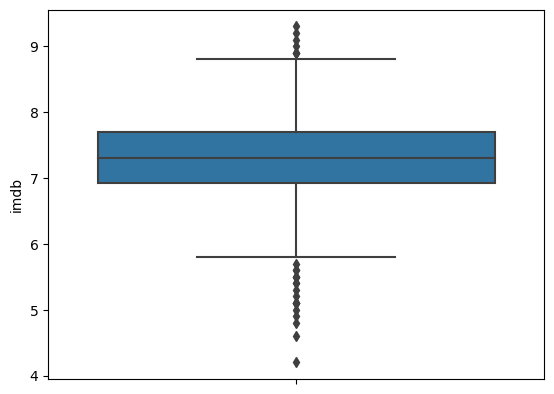

In [23]:
sb.boxplot(y = 'imdb', data = data)

<Axes: ylabel='imdb'>

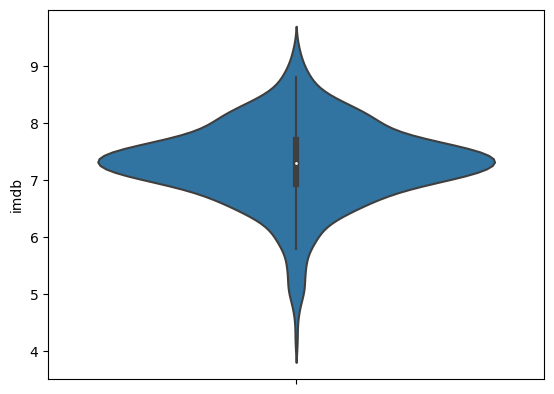

In [24]:
sb.violinplot(y = 'imdb', data = data)

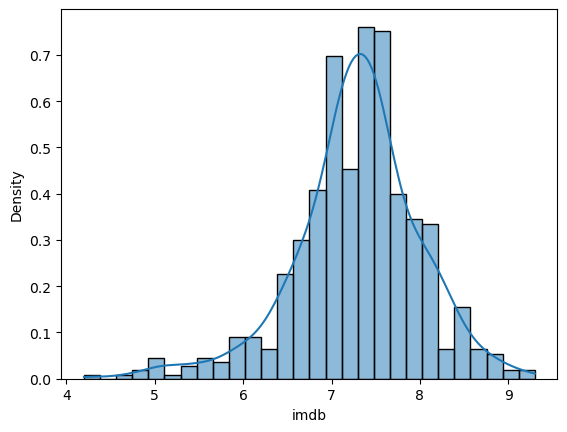

In [25]:
ax = sb.histplot(data, x = 'imdb', kde = True, stat = 'density', label = 'imdb')

Engagement - podstawowe statystyki opisowe

In [26]:
data['engagement'].describe()

count     606.000000
mean      209.156766
std       570.054146
min         7.000000
25%        26.000000
50%        51.000000
75%       112.750000
max      4487.000000
Name: engagement, dtype: float64

Ppnad 90% danych posiada parametr 'engagement' z przedziału [0,500]. W celu wyeliminowania wartości skrajnych oraz zwiększenia dokładności analizy rozpatrujemy wyłącznie dane z tego przedziału.

In [27]:
data[data['engagement'] < 500]['engagement'].describe()

count    568.000000
mean      83.045775
std       88.936464
min        7.000000
25%       25.000000
50%       47.000000
75%       97.250000
max      479.000000
Name: engagement, dtype: float64

<Axes: ylabel='engagement'>

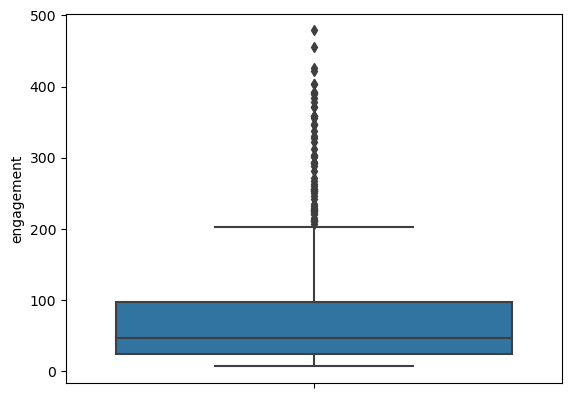

In [28]:
sb.boxplot(y = 'engagement', data = data[data['engagement'] < 500])

<Axes: ylabel='engagement'>

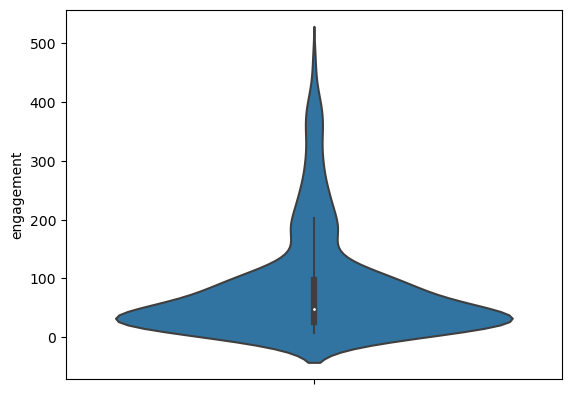

In [29]:
sb.violinplot(y = 'engagement', data = data[data['engagement'] < 500])

<Axes: xlabel='engagement', ylabel='Density'>

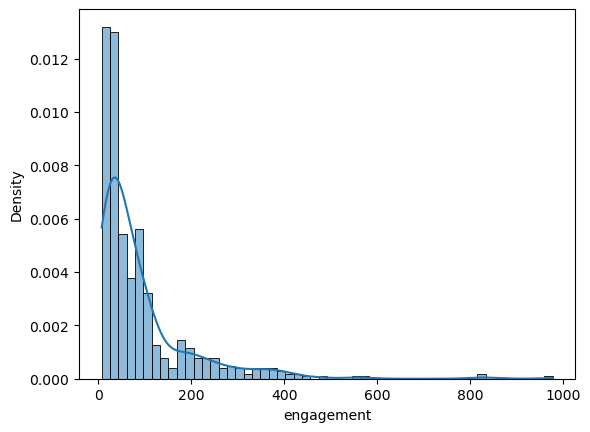

In [30]:
sb.histplot(data[data['engagement'] < 1000], x = 'engagement', kde = True, stat = 'density', label = 'engagement')

# Zależność zmiennych

W celu pełnego opisu zbioru danych konieczne jest zbadanie zależności pomiędzy zmiennymi. W przypadku zmiennych ilościowych zostanie zrealizowane obliczając macierz korelacji, w przypadku zależności oceny i zaangażowania od zmiennych opisowych, konieczna jest analiza każdej zmiennej z osobna, ponieważ nie ma możliwości uporządkowania pewnych zmiennych.

Ocena oraz zaanagażowanie społeczności w czasie

<Axes: xlabel='date_aired', ylabel='imdb'>

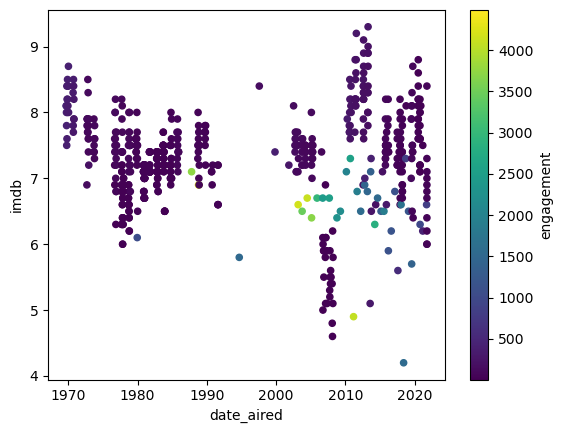

In [31]:
data.plot.scatter(x = 'date_aired', y = 'imdb', c = 'engagement')

Ponieważ w zbiorze danych istnieje kilka wartości odstających w kolumnie engagement, powinniśmy również zbadać zaangażowanie społeczności po odrzuceniu wartości skrajnych, gdyż zaburzają one dokładność wykresu i analizy

<Axes: xlabel='date_aired', ylabel='imdb'>

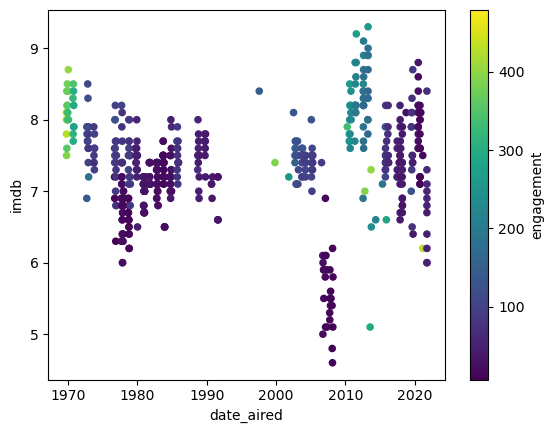

In [32]:
no_engagement_outliers_over_500 = data[data['engagement'] < 500]
no_engagement_outliers_over_500.plot.scatter(x = 'date_aired', y = 'imdb', c = 'engagement')

Ocena oraz zaangażowanie w zależności od motywu

C:\Users\mateu\AppData\Local\Temp\ipykernel_5708\3294091336.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  motive_plot = motive_plot.set_xticklabels(motive_plot.get_xticklabels(), rotation = 90)


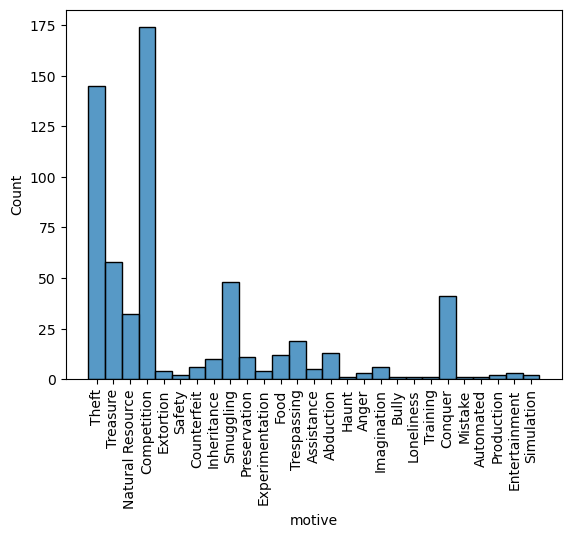

In [33]:
motive_plot = sb.histplot(data, x = 'motive', label = 'motive')
motive_plot = motive_plot.set_xticklabels(motive_plot.get_xticklabels(), rotation = 90)

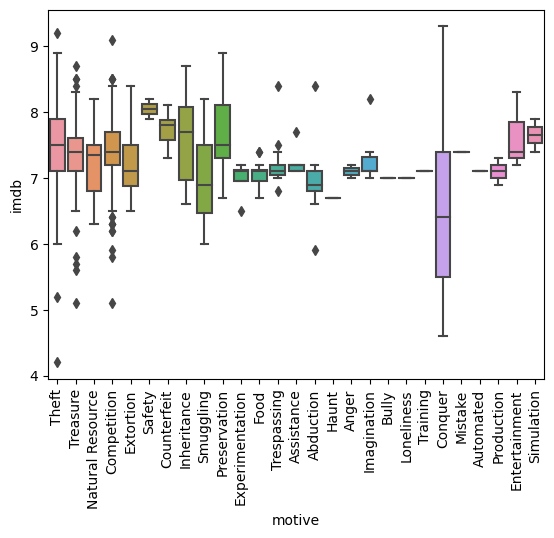

In [34]:
motive_plot = sb.boxplot(x = 'motive', y = 'imdb', data = data)
motive_plot = motive_plot.set_xticklabels(motive_plot.get_xticklabels(), rotation = 90)

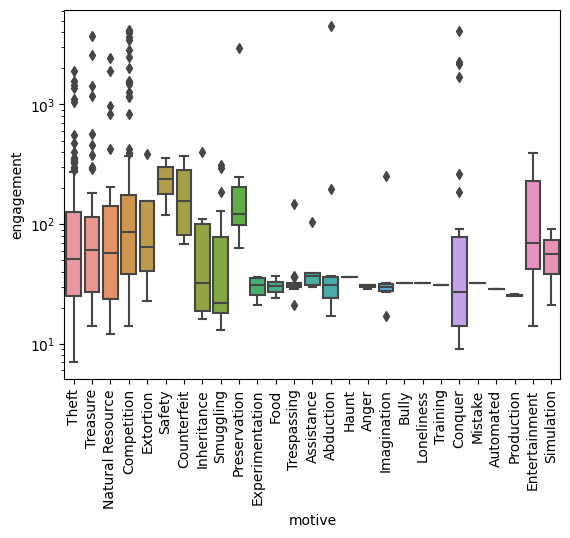

In [35]:
motive_plot = sb.boxplot(x = 'motive', y = 'engagement', data = data)
motive_plot.set_xticklabels(motive_plot.get_xticklabels(), rotation = 90)
motive_plot.set_yscale('log')

Ocena oraz zaangażowanie społeczności w zależności od nadawcy

C:\Users\mateu\AppData\Local\Temp\ipykernel_5708\113526584.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  network_plot = network_plot.set_xticklabels(network_plot.get_xticklabels(), rotation = 90)


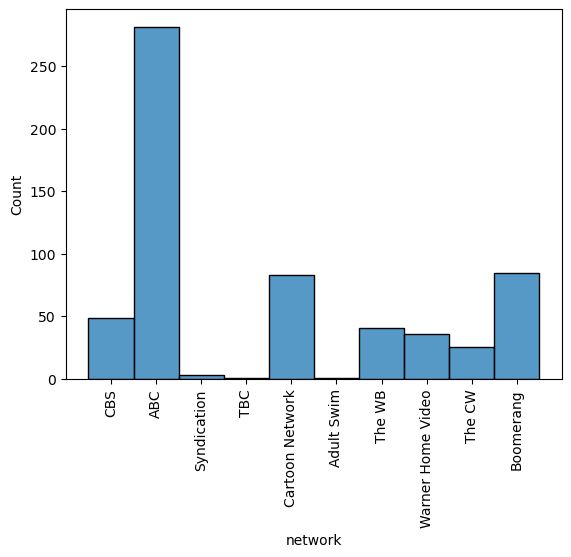

In [36]:
network_plot = sb.histplot(data, x = 'network', label = 'network')
network_plot = network_plot.set_xticklabels(network_plot.get_xticklabels(), rotation = 90)

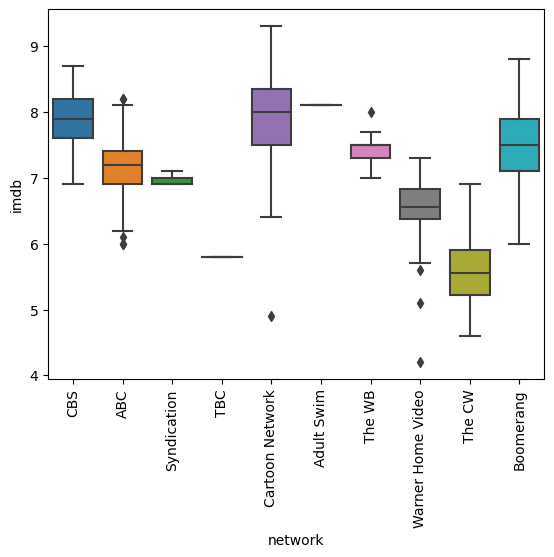

In [37]:
network_plot = sb.boxplot(x = 'network', y = 'imdb', data = data)
network_plot = network_plot.set_xticklabels(network_plot.get_xticklabels(), rotation = 90)

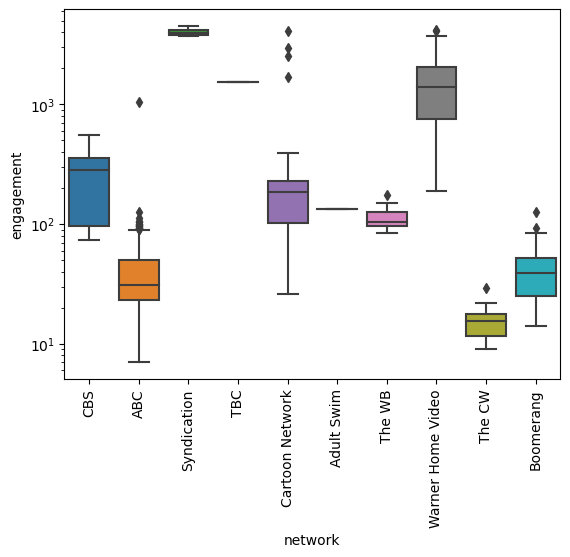

In [38]:
network_plot = sb.boxplot(x = 'network', y = 'engagement', data = data)
network_plot.set_xticklabels(network_plot.get_xticklabels(), rotation = 90)
network_plot.set_yscale('log')

Ocena oraz zaangażowanie społeczności w zależności od doboru aktorów

C:\Users\mateu\AppData\Local\Temp\ipykernel_5708\2407014804.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  fred_plot = fred_plot.set_xticklabels(fred_plot.get_xticklabels(), rotation = 90)


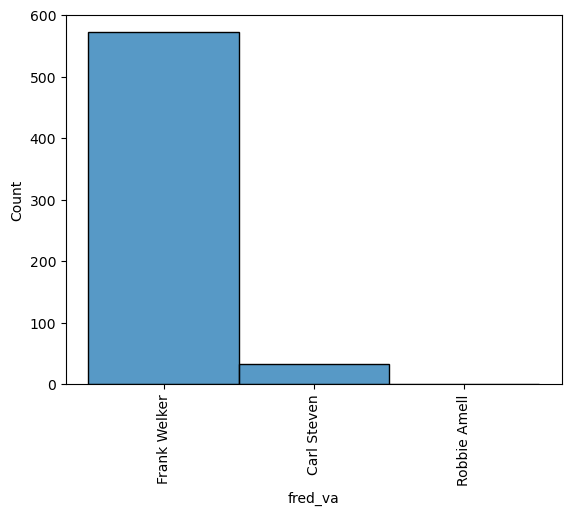

In [39]:
fred_plot = sb.histplot(data, x = 'fred_va', label = 'fred')
fred_plot = fred_plot.set_xticklabels(fred_plot.get_xticklabels(), rotation = 90)

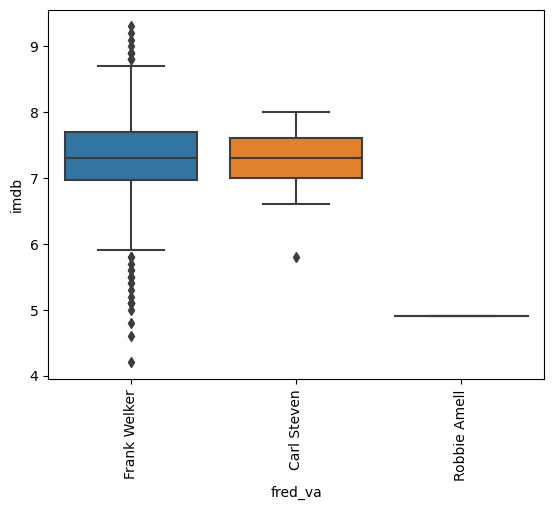

In [40]:
fred_plot = sb.boxplot(x = 'fred_va', y = 'imdb', data = data)
fred_plot = fred_plot.set_xticklabels(fred_plot.get_xticklabels(), rotation = 90)

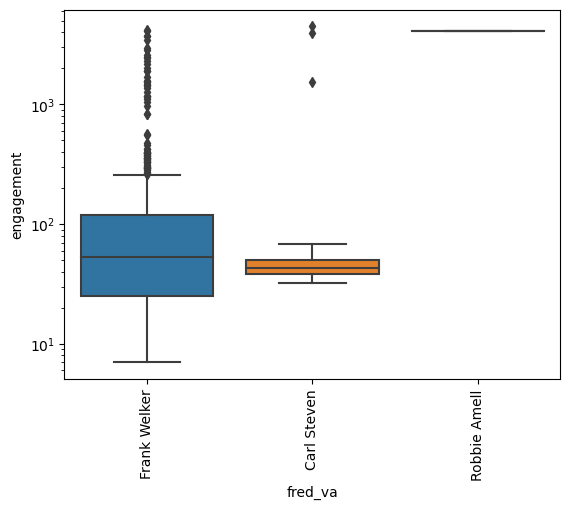

In [41]:
fred_plot = sb.boxplot(x = 'fred_va', y = 'engagement', data = data)
fred_plot.set_xticklabels(fred_plot.get_xticklabels(), rotation = 90)
fred_plot.set_yscale('log')

C:\Users\mateu\AppData\Local\Temp\ipykernel_5708\1757776920.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  velma_plot = velma_plot.set_xticklabels(velma_plot.get_xticklabels(), rotation = 90)


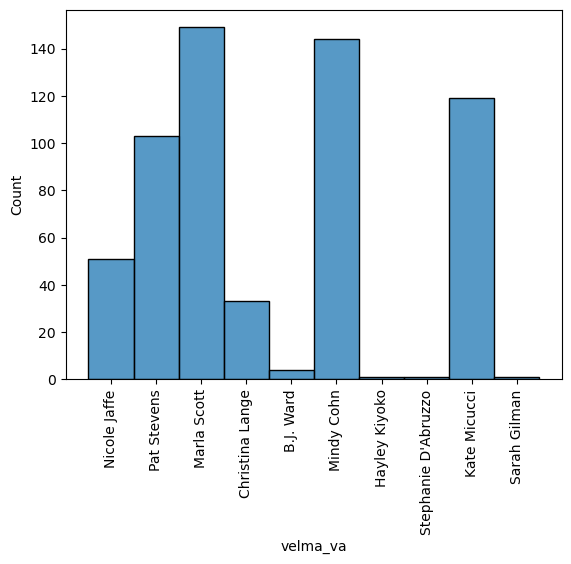

In [42]:
velma_plot = sb.histplot(data, x = 'velma_va', label = 'velma')
velma_plot = velma_plot.set_xticklabels(velma_plot.get_xticklabels(), rotation = 90)

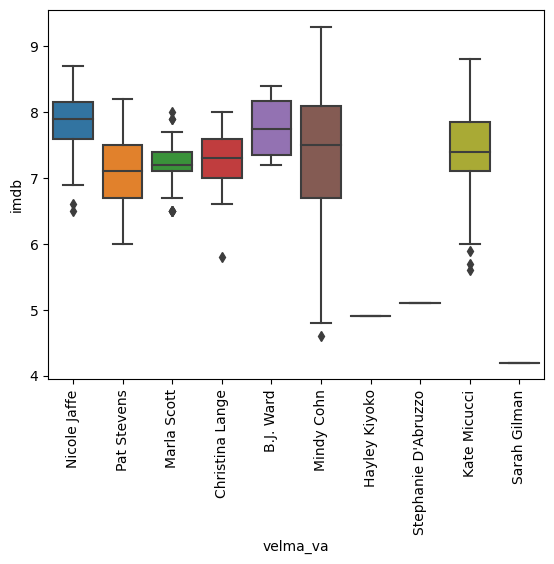

In [43]:
velma_plot = sb.boxplot(x = 'velma_va', y = 'imdb', data = data)
velma_plot = velma_plot.set_xticklabels(velma_plot.get_xticklabels(), rotation = 90)

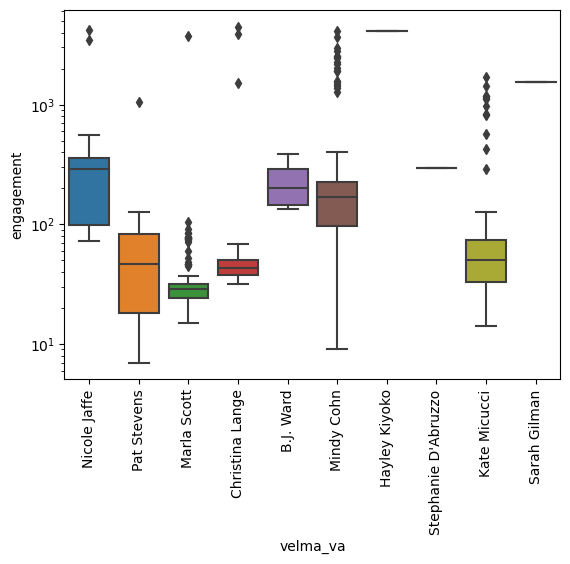

In [44]:
velma_plot = sb.boxplot(x = 'velma_va', y = 'engagement', data = data)
velma_plot.set_xticklabels(velma_plot.get_xticklabels(), rotation = 90)
velma_plot.set_yscale('log')

C:\Users\mateu\AppData\Local\Temp\ipykernel_5708\1248762252.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  daphne_plot = daphne_plot.set_xticklabels(daphne_plot.get_xticklabels(), rotation = 90)


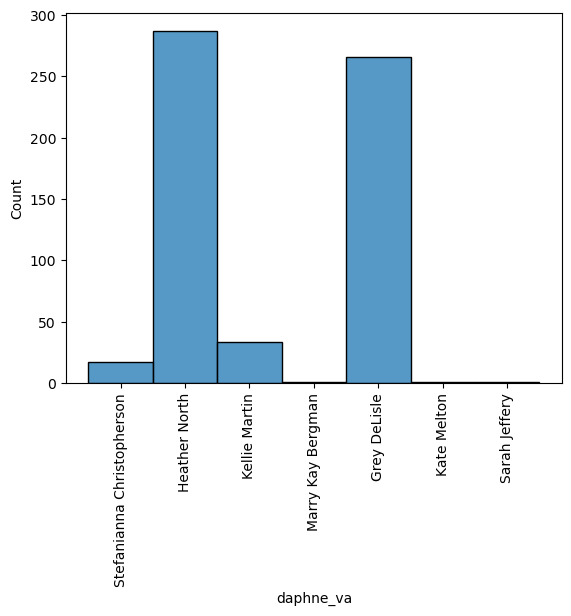

In [45]:
daphne_plot = sb.histplot(data, x = 'daphne_va', label = 'daphne')
daphne_plot = daphne_plot.set_xticklabels(daphne_plot.get_xticklabels(), rotation = 90)

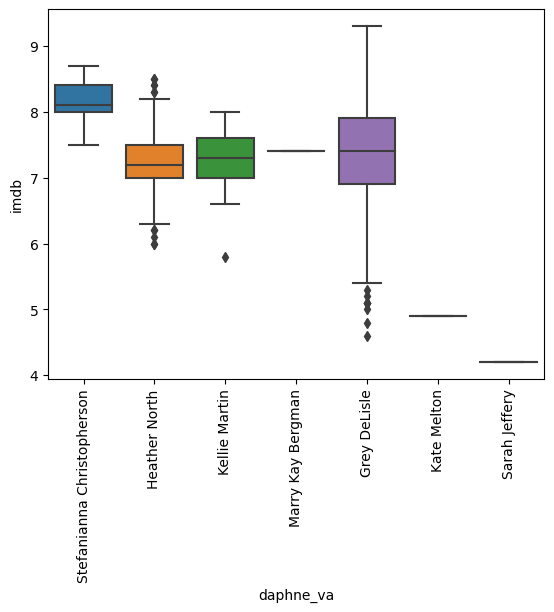

In [46]:
daphne_plot = sb.boxplot(x = 'daphne_va', y = 'imdb', data = data)
daphne_plot = daphne_plot.set_xticklabels(daphne_plot.get_xticklabels(), rotation = 90)

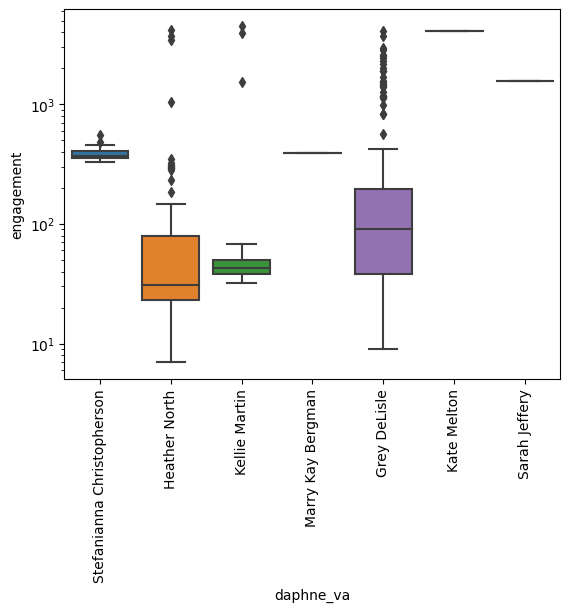

In [47]:
daphne_plot = sb.boxplot(x = 'daphne_va', y = 'engagement', data = data)
daphne_plot.set_xticklabels(daphne_plot.get_xticklabels(), rotation = 90)
daphne_plot.set_yscale('log')

C:\Users\mateu\AppData\Local\Temp\ipykernel_5708\3752273912.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  shaggy_plot = shaggy_plot.set_xticklabels(shaggy_plot.get_xticklabels(), rotation = 90)


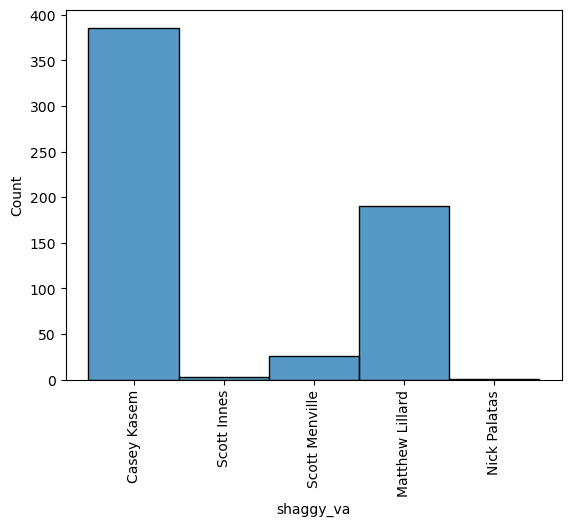

In [48]:
shaggy_plot = sb.histplot(data, x = 'shaggy_va', label = 'shaggy')
shaggy_plot = shaggy_plot.set_xticklabels(shaggy_plot.get_xticklabels(), rotation = 90)

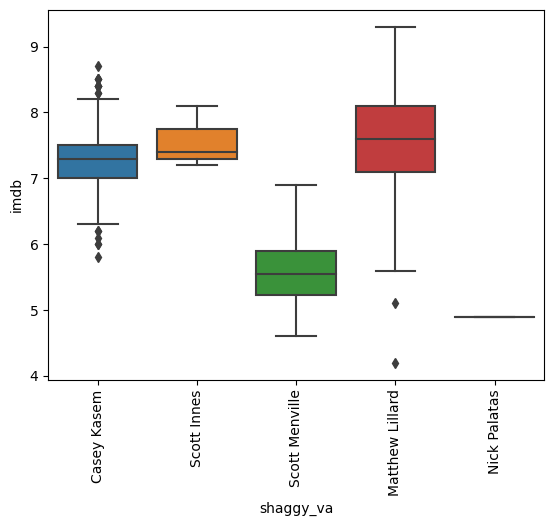

In [49]:
shaggy_plot = sb.boxplot(x = 'shaggy_va', y = 'imdb', data = data)
shaggy_plot = shaggy_plot.set_xticklabels(shaggy_plot.get_xticklabels(), rotation = 90)

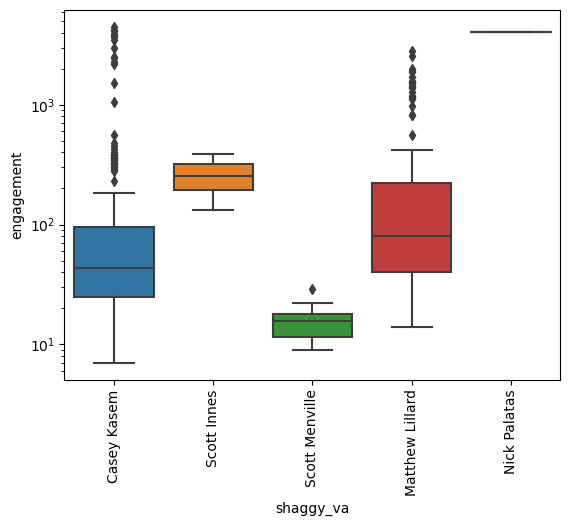

In [50]:
shaggy_plot = sb.boxplot(x = 'shaggy_va', y = 'engagement', data = data)
shaggy_plot.set_xticklabels(shaggy_plot.get_xticklabels(), rotation = 90)
shaggy_plot.set_yscale('log')

C:\Users\mateu\AppData\Local\Temp\ipykernel_5708\3047341647.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  scooby_plot = scooby_plot.set_xticklabels(scooby_plot.get_xticklabels(), rotation = 90)


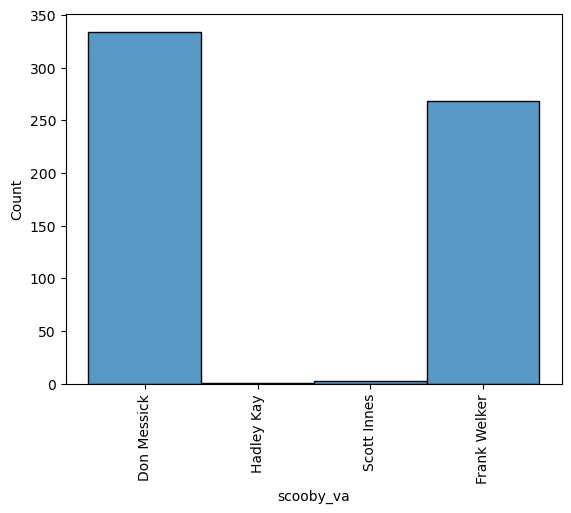

In [51]:
scooby_plot = sb.histplot(data, x = 'scooby_va', label = 'scooby')
scooby_plot = scooby_plot.set_xticklabels(scooby_plot.get_xticklabels(), rotation = 90)

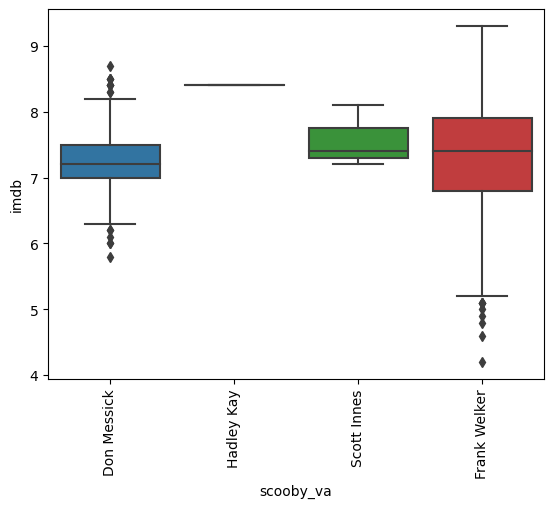

In [52]:
scooby_plot = sb.boxplot(x = 'scooby_va', y = 'imdb', data = data)
scooby_plot = scooby_plot.set_xticklabels(scooby_plot.get_xticklabels(), rotation = 90)

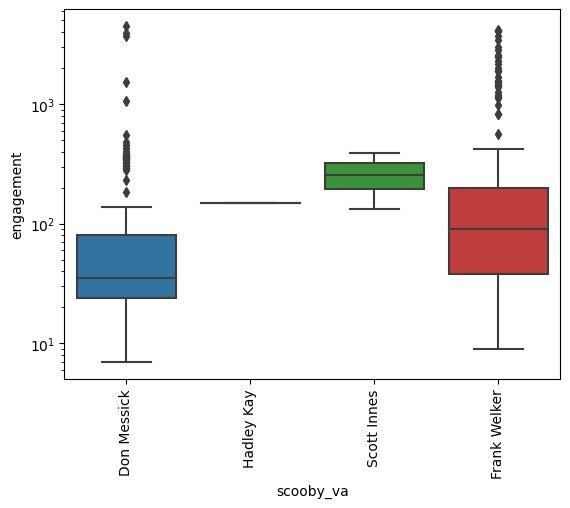

In [53]:
scooby_plot = sb.boxplot(x = 'scooby_va', y = 'engagement', data = data)
scooby_plot.set_xticklabels(scooby_plot.get_xticklabels(), rotation = 90)
scooby_plot.set_yscale('log')

Ocena oraz zaangażowanie społeczności w zależności od serii

C:\Users\mateu\AppData\Local\Temp\ipykernel_5708\3601418326.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  series_plot = series_plot.set_xticklabels(series_plot.get_xticklabels(), rotation = 90)


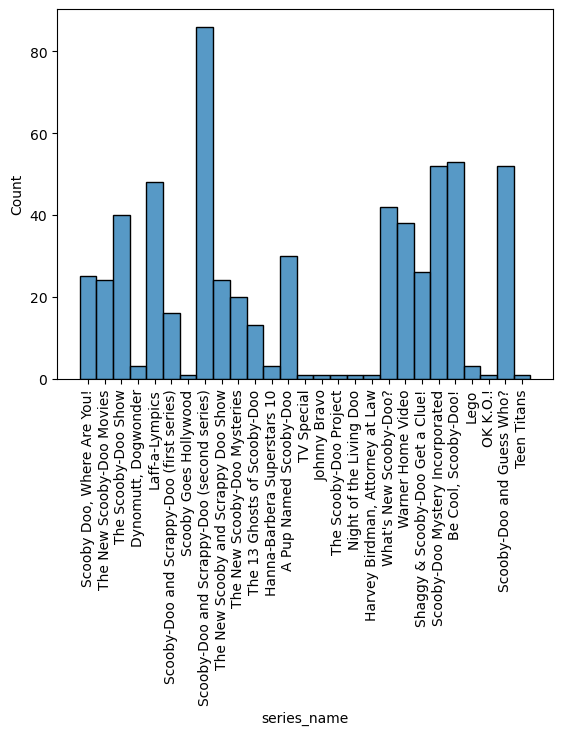

In [54]:
series_plot = sb.histplot(data, x = 'series_name', label = 'series')
series_plot = series_plot.set_xticklabels(series_plot.get_xticklabels(), rotation = 90)

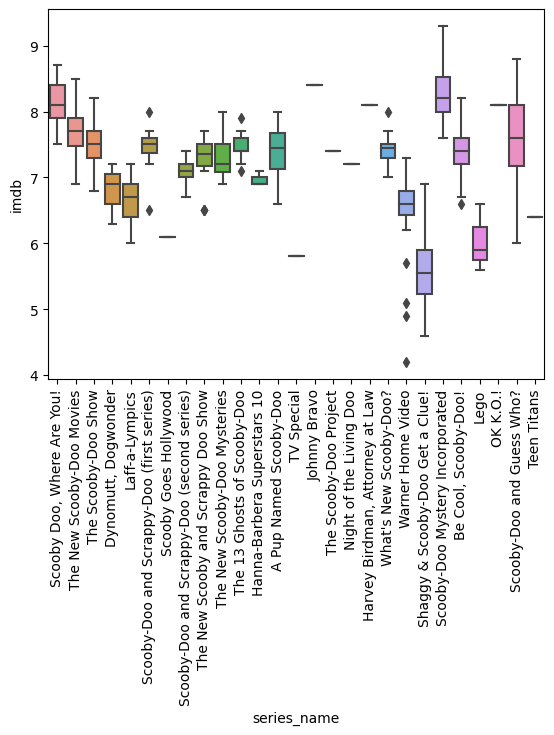

In [55]:
series_plot = sb.boxplot(x = 'series_name', y = 'imdb', data = data)
series_plot = series_plot.set_xticklabels(series_plot.get_xticklabels(), rotation = 90)

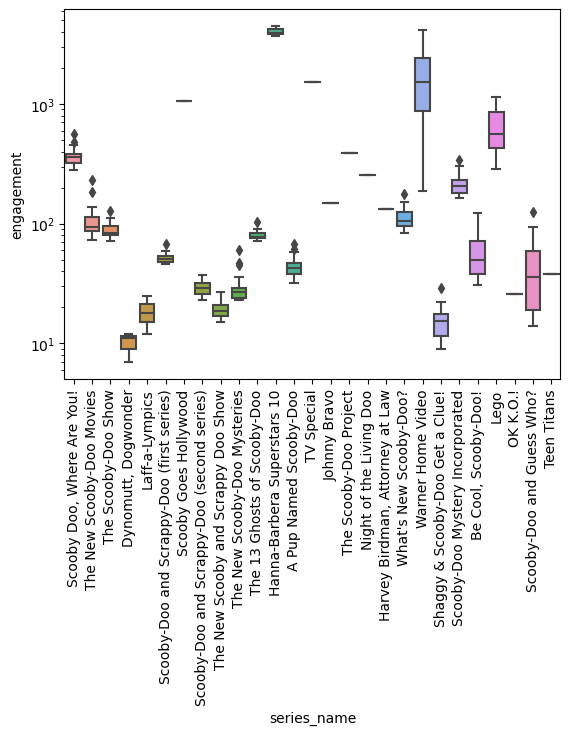

In [56]:
series_plot = sb.boxplot(x = 'series_name', y = 'engagement', data = data)
series_plot.set_xticklabels(series_plot.get_xticklabels(), rotation = 90)
series_plot.set_yscale('log')

Ocena oraz zaangażowanie społeczności w zależności od sezonu/typu

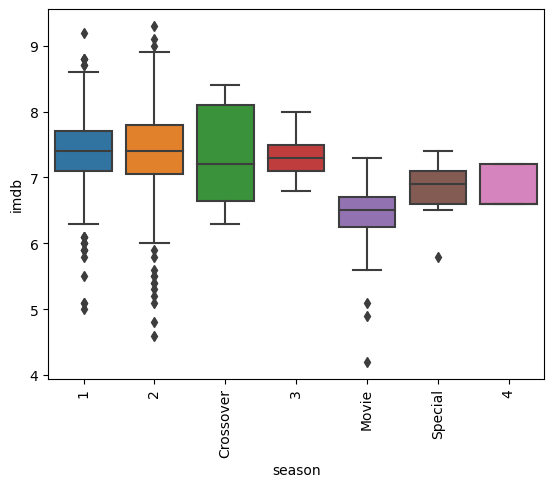

In [57]:
season_plot = sb.boxplot(x = 'season', y = 'imdb', data = data)
season_plot = season_plot.set_xticklabels(season_plot.get_xticklabels(), rotation = 90)

### Zależność poszczególnych zmiennych numerycznych

Macierz kowariancji zmiennych numerycznych

In [58]:
data.cov(numeric_only = True)

,id,imdb,engagement,run_time,monster_real,monster_amount,caught_fred,caught_daphne,caught_velma,caught_shaggy,...,zoinks,groovy,scooby_doo_where_are_you,rooby_rooby_roo,batman,scooby-dum,scrappy-doo,hex_girls,blue_falcon,catchphrases
id,31786.066631,0.914836,12715.421741,683.332272,-14.086147,50.985762,8.181761,5.536462,8.563334,-8.047819,...,-159.261640,-1.269282,-12.293454,-2.149775,-0.080059,-6.160912,-22.403077,1.118935,-9.649742,-17.649407
imdb,0.914836,0.503853,-70.433831,-1.652584,-0.110949,-0.506276,0.045220,-0.003176,-0.004788,0.008347,...,-0.133663,-0.006310,-0.006175,-0.134209,0.001911,-0.009027,-0.019338,0.003587,-0.031797,0.095156
engagement,12715.421741,-70.433831,324961.729103,7154.471121,-12.464796,214.760172,8.272332,7.212839,2.689684,10.272967,...,375.339288,25.452830,0.568576,104.860999,2.248550,-4.807711,-26.746627,6.116060,-7.673014,860.147091
run_time,683.332272,-1.652584,7154.471121,254.358970,-1.522172,8.896233,0.589343,0.294419,0.555636,0.310018,...,5.181019,0.491681,0.421076,2.787142,0.148362,-0.226073,-2.507236,0.075949,-0.402872,24.604370
monster_real,-14.086147,-0.110949,-12.464796,-1.522172,0.184884,0.252020,-0.033587,-0.010899,-0.017358,-0.031449,...,-0.012252,-0.001942,-0.010365,0.027226,-0.001615,-0.001904,0.079252,-0.002018,0.003208,-0.370395
monster_amount,50.985762,-0.506276,214.760172,8.896233,0.252020,4.921845,-0.097041,-0.013338,-0.008875,-0.032916,...,-0.101503,0.004659,-0.025819,0.166473,-0.001364,-0.038027,-0.098890,0.004080,-0.068276,0.003371
caught_fred,8.181761,0.045220,8.272332,0.589343,-0.033587,-0.097041,0.195415,0.007978,-0.000701,-0.011216,...,-0.048799,0.002556,-0.005043,-0.032578,-0.000104,0.004105,-0.060448,0.004416,0.006996,-0.013059
caught_daphne,5.536462,-0.003176,7.212839,0.294419,-0.010899,-0.013338,0.007978,0.042640,0.013362,0.008837,...,-0.013984,0.002348,-0.001154,-0.001767,-0.000295,-0.001252,-0.007119,-0.000368,-0.000777,0.022388
caught_velma,8.563334,-0.004788,2.689684,0.555636,-0.017358,-0.008875,-0.000701,0.013362,0.066031,0.005259,...,-0.053370,0.000128,-0.001470,-0.007223,-0.000469,-0.001994,-0.014276,0.001066,-0.002217,0.054938
caught_shaggy,-8.047819,0.008347,10.272967,0.310018,-0.031449,-0.032916,-0.011216,0.008837,0.005259,0.117197,...,0.119636,0.000398,0.001271,0.000142,0.002411,0.004462,-0.011887,0.000535,0.000884,0.072400


Macierz korelacji zmiennych numerycznych

In [59]:
correlation_matrix = data.corr(numeric_only = True)
correlation_matrix

,id,imdb,engagement,run_time,monster_real,monster_amount,caught_fred,caught_daphne,caught_velma,caught_shaggy,...,zoinks,groovy,scooby_doo_where_are_you,rooby_rooby_roo,batman,scooby-dum,scrappy-doo,hex_girls,blue_falcon,catchphrases
id,1.000000,0.007229,0.125111,0.240320,-0.183749,0.128904,0.103812,0.150386,0.186918,-0.131856,...,-0.313685,-0.045640,-0.163479,-0.015905,-0.005541,-0.209102,-0.282599,0.069323,-0.238329,-0.024040
imdb,0.007229,1.000000,-0.174066,-0.145978,-0.363514,-0.321493,0.144113,-0.021666,-0.026251,0.034351,...,-0.066124,-0.056990,-0.020625,-0.249400,0.033218,-0.076956,-0.061270,0.055818,-0.197248,0.032555
engagement,0.125111,-0.174066,1.000000,0.786933,-0.050853,0.169814,0.032827,0.061275,0.018362,0.052641,...,0.231211,0.286238,0.002365,0.242640,0.048671,-0.051033,-0.105520,0.118508,-0.059269,0.366425
run_time,0.240320,-0.145978,0.786933,1.000000,-0.221968,0.251431,0.083592,0.089400,0.135579,0.056781,...,0.114075,0.197636,0.062596,0.230516,0.114785,-0.085774,-0.353551,0.052600,-0.111230,0.374643
monster_real,-0.183749,-0.363514,-0.050853,-0.221968,1.000000,0.264193,-0.176702,-0.122755,-0.157101,-0.213645,...,-0.010006,-0.028954,-0.057150,0.083523,-0.046337,-0.026792,0.414514,-0.051850,0.032848,-0.209192
monster_amount,0.128904,-0.321493,0.169814,0.251431,0.264193,1.000000,-0.098949,-0.029115,-0.015569,-0.043340,...,-0.016066,0.013462,-0.027592,0.098979,-0.007585,-0.103721,-0.100246,0.020316,-0.135514,0.000369
caught_fred,0.103812,0.144113,0.032827,0.083592,-0.176702,-0.098949,1.000000,0.087400,-0.006171,-0.074112,...,-0.038764,0.037063,-0.027048,-0.097209,-0.002893,0.056190,-0.307527,0.110340,0.069688,-0.007174
caught_daphne,0.150386,-0.021666,0.061275,0.089400,-0.122755,-0.029115,0.087400,1.000000,0.251824,0.125012,...,-0.023781,0.072908,-0.013247,-0.011290,-0.017602,-0.036687,-0.077533,-0.019697,-0.016576,0.026329
caught_velma,0.186918,-0.026251,0.018362,0.135579,-0.157101,-0.015569,-0.006171,0.251824,1.000000,0.059779,...,-0.072933,0.003198,-0.013564,-0.037075,-0.022527,-0.046951,-0.124943,0.045842,-0.037999,0.051919
caught_shaggy,-0.131856,0.034351,0.052641,0.056781,-0.213645,-0.043340,-0.074112,0.125012,0.059779,1.000000,...,0.122716,0.007457,0.008803,0.000546,0.086906,0.078873,-0.078088,0.017249,0.011367,0.051358


In [60]:
numeric_data = data.select_dtypes(include = np.number)

<Axes: >

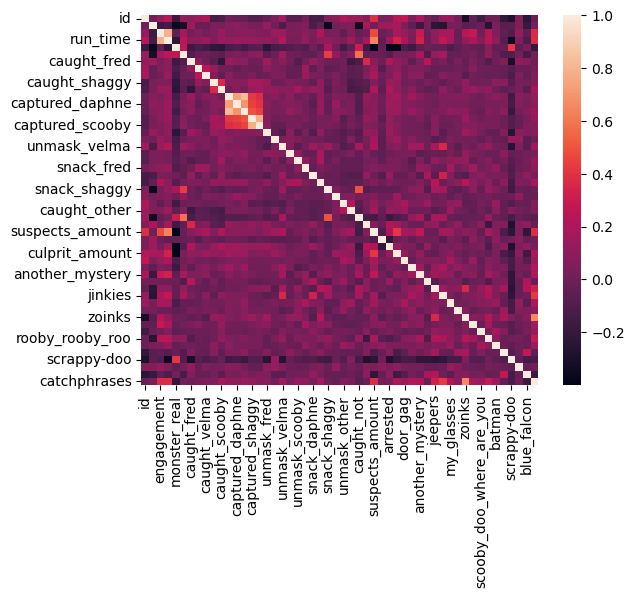

In [61]:
sb.heatmap(correlation_matrix)

Jak można zaobserwować w macierzy korelacji, bardzo wiele cech nie jest skorelowanych. Poniżej możemy zobaczyć cechy, ktore łączy co najmniej słaba korelacja

<Axes: >

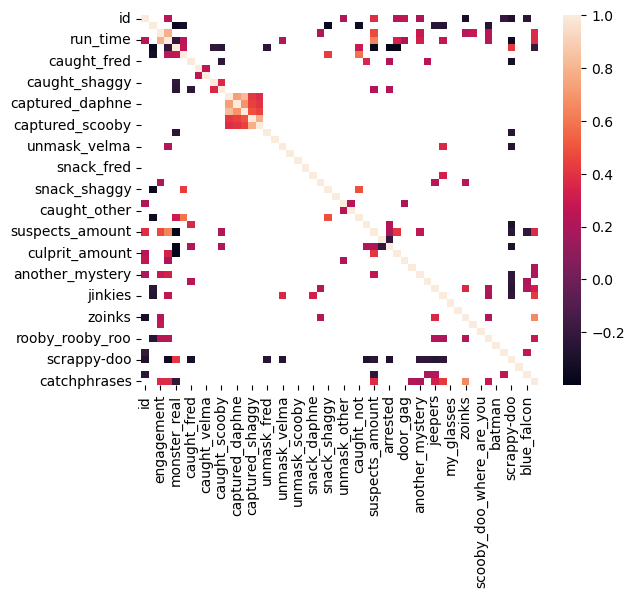

In [62]:
sb.heatmap(correlation_matrix[abs(correlation_matrix) >= 0.2])

Ponieważ nasza analiza skupia się głównie na ocenie oraz popularności poszczególnych produkcji, skupimy się na wyłącznie na cechach, które są co najmniej słabo skorelowane z 'imdb' lub 'engagement'

Choć żadna zmienna nie wykazuje silnej korelacji z ostateczną oceną użytkowników, to istnieją pewne cechy, które w przeciętnym (lub małym - zależnie od przyjętej klasyfikacji, przyjęta została <a href='https://home.agh.edu.pl/~dabek/Dydaktyka/Studia_dzienne/Materia3y/Inne/Miary_zale_nooeci_miedzy_cechami.pdf'>klasyfikacja Stanisza</a>) stopniu korelują z ostateczną oceną produkcji przez widzów. 

W przeciętnym stopniu na ocenę wpływają:
1. realność potwora (sytuacja, w której potwór okazuje się nie być człowiekiem, robotem lub czymś wytrenowanym przez człowieka) negatywnie wpływa na ocenę
2. ilość potworów - im więcej potworów występuje w produkcji, tym gorzej jest ona oceniana
3. niepowodzenie w schwytaniu potwora - niepowodzenie negatywnie wpływa na ocenę produkcji
4. zaoferowanie scooby-chrupki przez Kudłatego negatywnie wpływa na ocenę :)

<Axes: >

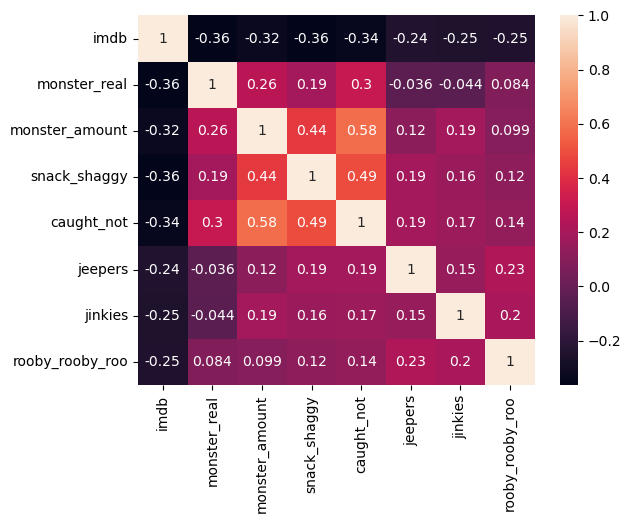

In [63]:
columns_to_drop = list(filter(lambda label: abs(correlation_matrix['imdb'][label]) < 0.2, correlation_matrix.columns))

correlated_data = data.drop(columns = columns_to_drop)

sb.heatmap(correlated_data.corr(numeric_only = True), annot = True)

Co ciekawe, ocena widzów wykazuje jedynie bardzo słabe powiązanie z zaangażowaniem społeczności (ilością osób oceniających daną produkcję). Współczynnik korelacji pomiędzy tymi cechami wynosi jedynie około -0.18, co wskazuje na bardzo słabą zależność ujemną. Oznacza to, że wraz ze wzrostem zaangażowania spada ocena

In [64]:
correlation_matrix['imdb']['engagement']

-0.17406581249233535

Zgodnie z macierzą korelacji, istnieją pewne cechy, które w silnym i przeciętnym (przyjęta została <a href='https://home.agh.edu.pl/~dabek/Dydaktyka/Studia_dzienne/Materia3y/Inne/Miary_zale_nooeci_miedzy_cechami.pdf'>klasyfikacja Stanisza</a>) stopniu korelują z zaangażowaniem widzów. 

W bardzo wysokim stopniu na zaangażowanie widzów wpływa czas trwania produkcji, wartość wskaźnika wskazuje na bardzo wysoką korelację. Czym dłuższa jest produkcja, tym bardziej społeczność jest zaangażowana w jej ocenianie.

Na zaangażowanie w przeciętnym stopniu wpływają także:
1. ilość podejrzanych - im więcej podejrzanych, tym większe zaangażowanie
2. ilość zwrotów typowych dla poszczególnych bohaterów - im więcek powiedzonek, tym większe zaangażowanie

<Axes: >

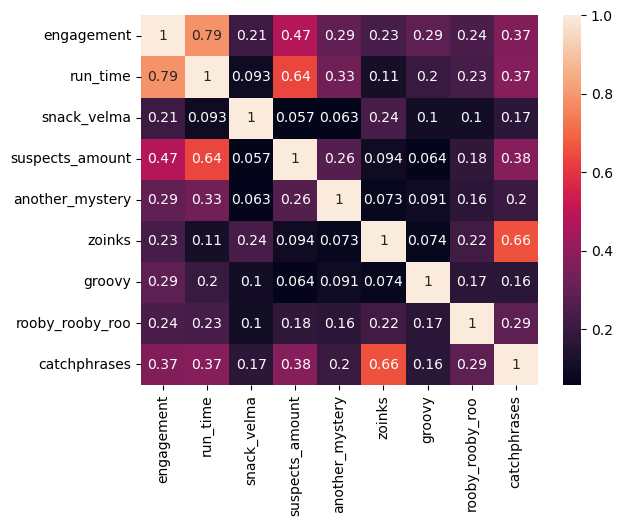

In [65]:
columns_to_drop = list(filter(lambda label: abs(correlation_matrix['engagement'][label]) < 0.2, correlation_matrix.columns))

correlated_data = data.drop(columns = columns_to_drop)

sb.heatmap(correlated_data.corr(numeric_only = True), annot = True)

W trakcie analizowania korelacji z oceną i zaangażowaniem widzów, zauważalny jest wyróżniający się fragment heatmapy związany z porywaniem poszczególnych bohaterów przez potwory. Choć nie dotyczy to bezpośrednio określonego przez nas celu opracowania, to jest to pewien zestaw cech, który wykazuje bardzo silną korelację (zgodnie z <a href='https://home.agh.edu.pl/~dabek/Dydaktyka/Studia_dzienne/Materia3y/Inne/Miary_zale_nooeci_miedzy_cechami.pdf'>klasyfikacją Stanisza</a>)

Na poniższym fragmencie heatmapy można dostrzec silne zależności pomiędzy faktem złapania poszczególnych bohaterów. Przykładowo, schwytanie Freda, znacznie mocniej koreluje ze schwytaniem Daphne lub Velmy niż ze schwytaniem Kudłatego lub Scoobiego, schwytanie Kudłatego natomiast bardzo mocno koreluje ze schwytaniem Scoobiego. Dane znacznie pokrywają się z grupami na jakie zazwyczaj dzieliła się grupa młodych detektywów :)

<Axes: >

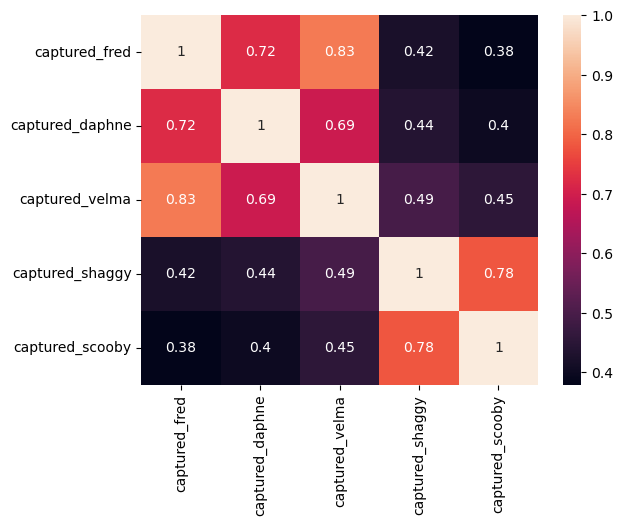

In [66]:
columns_to_drop = list(filter(lambda label: abs(correlation_matrix['captured_daphne'][label]) < 0.3, correlation_matrix.columns))

correlated_data = data.drop(columns = columns_to_drop)

sb.heatmap(correlated_data.corr(numeric_only = True), annot = True)

# Regresja liniowa

Kiedy wiemy już które zmienne ze sobą korelują, możemy podjąć próbę wyznaczenia zależności pomiędzy poszczególnymi zmiennymi. Do tego celu wykorzystana zostanie regresja liniowa. Ponieważ zmienne nie są mocno skorelowane, dopasowanie prostej może być niedokładne.

Przykładowa regresja liniowa dla zależności zmiennych 'imdb' od 'monster_amount' oraz 'engagement' od 'run_time'

<Axes: xlabel='monster_amount', ylabel='imdb'>

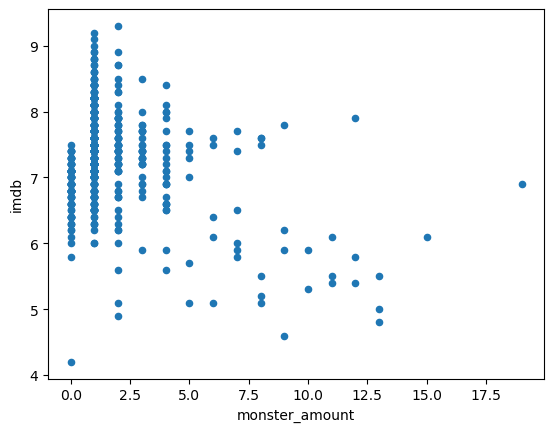

In [67]:
data.plot.scatter(x = 'monster_amount', y = 'imdb')

In [68]:
xs = data['monster_amount'].values.reshape((-1, 1))
ys = data['imdb'].values

model = LinearRegression(fit_intercept = True).fit(xs, ys)

d, m, b = model.score(xs, ys), model.coef_, model.intercept_
d, m, b

(0.10335762564973139, array([-0.10286296]), 7.461485644745125)

Zgodnie z informacją zwracają przez funkcję score(), jedynie około 10% wyników pokrywa się z przewidywaniem (mimo że jest to cecha najmnocniej skorelowana z 'imdb'). Zgodnie z wyznaczoną funkcją, w przybliżeniu równą $I = -0.1*MA + 7.47$ wartość oceny stopniowo maleje wraz ze wzrostem ilości antagonistów.

<Axes: xlabel='monster_amount', ylabel='imdb'>

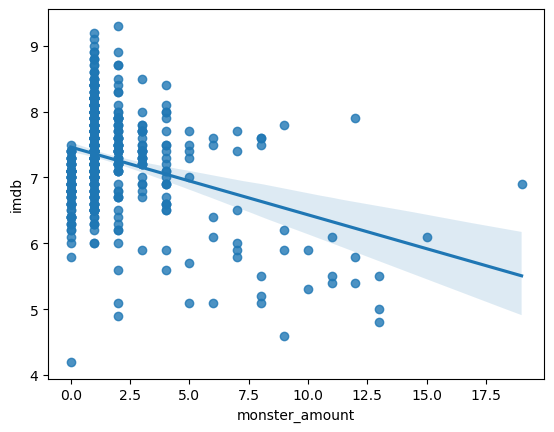

In [69]:
sb.regplot(data = data, x = 'monster_amount', y = 'imdb')

W trakcie badania zależności cechy 'engagement' od 'runtime' zostały odrzucone wartości skrajne, w tym celu usunięto około 1% wartości (rekordy z wartością 'engagement' większą niż 5000). Dzięki temu wskaźnik dopasowania wzrasta o około $50\%$ (z poziomu 0.4 do 0.6), ponieważ wartości te znacząco zaburzały pomiary

In [72]:
xs = data['run_time'].values.reshape((-1, 1))
ys = data['engagement'].values

model = LinearRegression(fit_intercept = True).fit(xs, ys)

d, m, b = model.score(xs, ys), model.coef_, model.intercept_
d, m, b

(0.6192639464779743, array([28.12745756]), -432.4370393770009)

<Axes: xlabel='run_time', ylabel='engagement'>

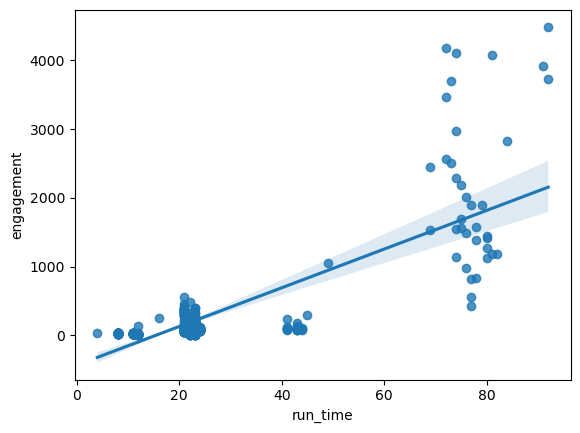

In [74]:
sb.regplot(data = data, x = 'run_time', y = 'engagement')

Zbadane zostały także dwie inne przykładowe zależności, które wykazywały się wysokim współczynnikiem korelacji:
1. ilość podejrzanych w zależności od czasu trwania odcinka (dopasowanie prostej na poziomie ~40%)
2. ilość powiedzonek typowych dla bohaterów w zależności od ilości wypowiedzianych 'zoinks' przez Kudłatego (dopasowanie prostej na poziomie ~43%)

In [75]:
xs = data['run_time'].values.reshape((-1, 1))
ys = data['suspects_amount'].values

model = LinearRegression(fit_intercept = True).fit(xs, ys)

d, m, b = model.score(xs, ys), model.coef_, model.intercept_
d, m, b

(0.40590206062436285, array([0.10238908]), 0.4763626332947686)

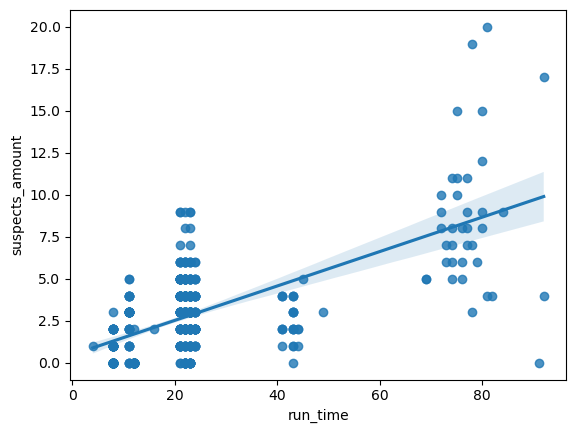

In [76]:
ax = sb.regplot(data = data, x = 'run_time', y = 'suspects_amount')

In [77]:
xs = data['zoinks'].values.reshape((-1, 1))
ys = data['catchphrases'].values

model = LinearRegression(fit_intercept = True).fit(xs, ys)

d, m, b = model.score(xs, ys), model.coef_, model.intercept_
d, m, b

(0.4357838517465148, array([0.9545688]), 1.6941421441594824)

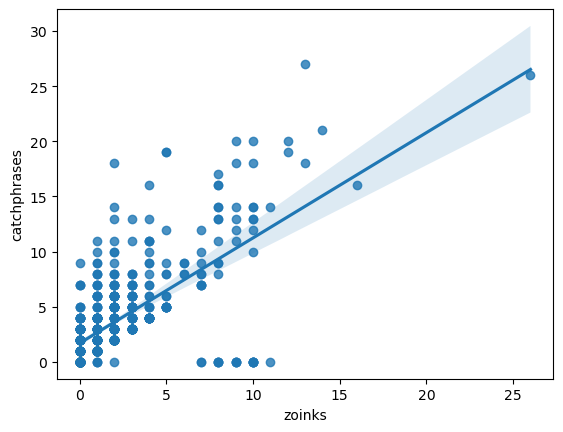

In [78]:
ax = sb.regplot(data = data, x = 'zoinks', y = 'catchphrases')

# Testy statystyczne i badanie hipotez

W celu lepszej analizy zbioru danych wykonujemy poszczególne testy statystyczne dla cech 'imdb' oraz 'engagement'

Test normalności - badamy czy rozkłady cech 'engagement' oraz 'imdb' są normalne

<Axes: xlabel='engagement', ylabel='Density'>

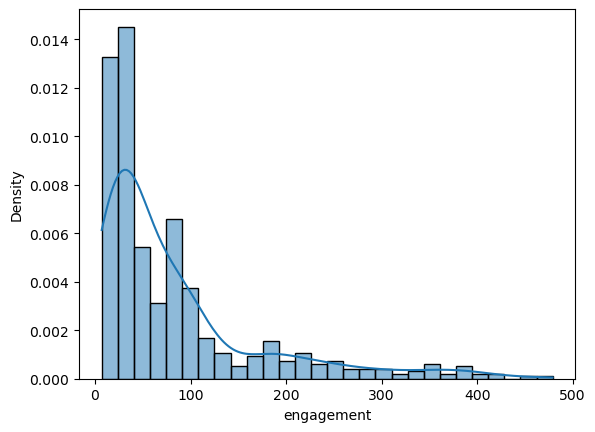

In [79]:
sb.histplot(data[data['engagement'] < 500], x = 'engagement', kde = True, stat = 'density', label = 'engagement')

In [80]:
ss.normaltest(data['engagement'], nan_policy = 'omit', axis = None)

NormaltestResult(statistic=632.2237982698382, pvalue=5.180200169364377e-138)

<Axes: xlabel='imdb', ylabel='Density'>

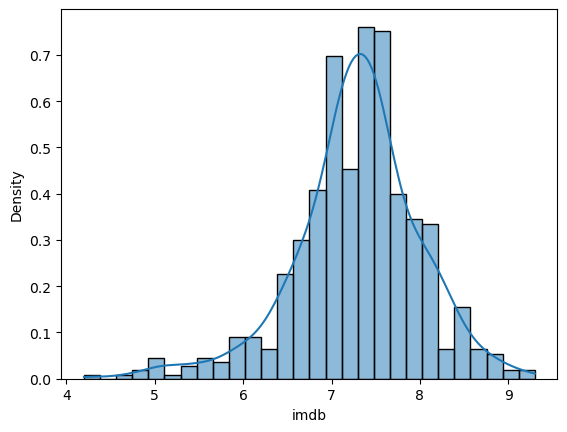

In [81]:
sb.histplot(data = data, x = 'imdb', kde = True, stat = 'density', label = 'engagement')

In [82]:
ss.normaltest(data['imdb'], nan_policy = 'omit', axis = None)

NormaltestResult(statistic=58.68916408180074, pvalue=1.8022288844574806e-13)

Dla obu zmiennych, obliczona p-wartość jest bardzo bliska zeru, co pozwala nam stwierdzić (odrzucić hipotezę zerową $H_0$ - rozkład normalny), że rozkłady tych zmiennych nie są normalne

Zostały też przeprowadzone przykładowe testy normalności dla cechy 'imdb' w pewnych podkategoriach 'network'. Wartości zwracane przez testy przeprowadzone dla danych zgromadzonych osobno dla stacji Boomerang oraz ABC nie pozwalają na odrzucenie hipotezy zerowej $H_0$ - rozkład normalny w danej podkategorii.

<Axes: xlabel='imdb', ylabel='Density'>

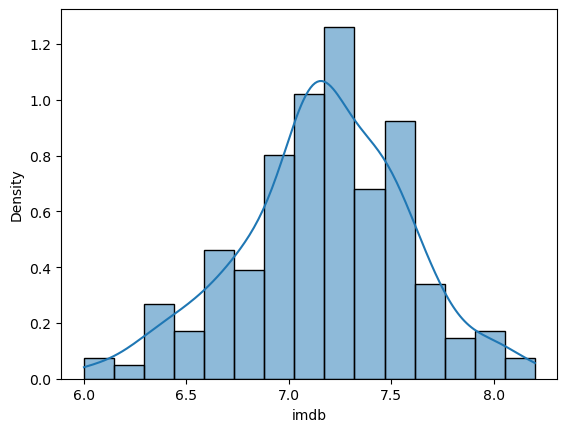

In [83]:
sb.histplot(data = data[data['network'] == 'ABC'], x = 'imdb', kde = True, stat = 'density', label = 'engagement')

In [84]:
ss.normaltest(data[data['network'] == 'ABC']['imdb'], nan_policy = 'omit', axis = None)

NormaltestResult(statistic=3.207508456797428, pvalue=0.201139973362446)

<Axes: xlabel='imdb', ylabel='Density'>

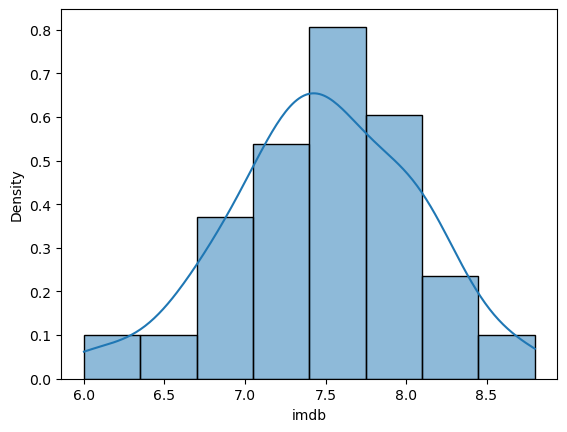

In [85]:
sb.histplot(data = data[data['network'] == 'Boomerang'], x = 'imdb', kde = True, stat = 'density', label = 'engagement')

In [86]:
ss.normaltest(data[data['network'] == 'Boomerang']['imdb'], nan_policy = 'omit', axis = None)

NormaltestResult(statistic=0.8213122644320303, pvalue=0.6632149506496635)

<Axes: xlabel='imdb', ylabel='Density'>

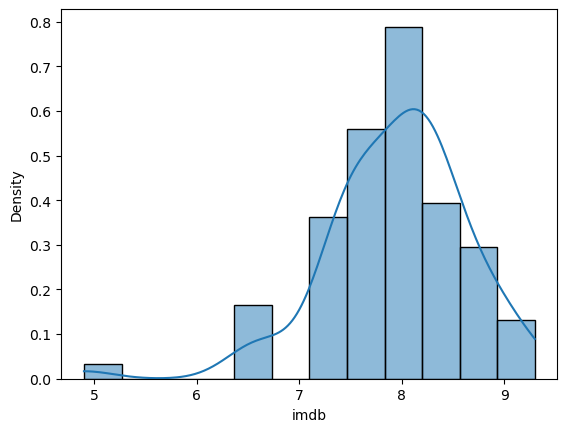

In [87]:
sb.histplot(data = data[data['network'] == 'Cartoon Network'], x = 'imdb', kde = True, stat = 'density', label = 'engagement')

In [88]:
ss.normaltest(data[data['network'] == 'Cartoon Network']['imdb'], nan_policy = 'omit', axis = None)

NormaltestResult(statistic=25.666767575952697, pvalue=2.6701289576414453e-06)

Zostały też przeprowadzone przykładowe testy normalności dla cechy 'engagement' w pewnych podkategoriach 'network'. Wartości zwracane przez testy przeprowadzone dla danych zgromadzonych osobno dla stacji Boomerang oraz ABC pozwalają na odrzucenie hipotezy zerowej $H_0$ - rozkład normalny w danej podkategorii, ponieważ p-wartości są bardzo bliskie zeru.

C:\Users\mateu\AppData\Local\Temp\ipykernel_5708\196895213.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sb.histplot(data = data[data['network'] == 'ABC'][data['engagement'] < 500], x = 'engagement', kde = True, stat = 'density', label = 'engagement')


<Axes: xlabel='engagement', ylabel='Density'>

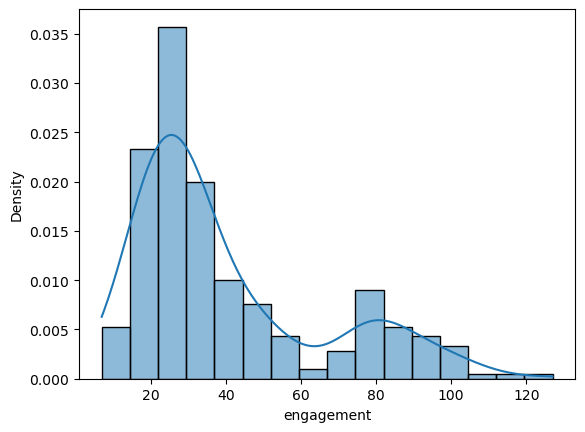

In [89]:
sb.histplot(data = data[data['network'] == 'ABC'][data['engagement'] < 500], x = 'engagement', kde = True, stat = 'density', label = 'engagement')

In [90]:
ss.normaltest(data[data['network'] == 'ABC'][data['engagement'] < 500]['engagement'], nan_policy = 'omit', axis = None)

C:\Users\mateu\AppData\Local\Temp\ipykernel_5708\1274314662.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ss.normaltest(data[data['network'] == 'ABC'][data['engagement'] < 500]['engagement'], nan_policy = 'omit', axis = None)


NormaltestResult(statistic=48.250671584246504, pvalue=3.3304260235562615e-11)

C:\Users\mateu\AppData\Local\Temp\ipykernel_5708\2766402827.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sb.histplot(data = data[data['network'] == 'Boomerang'][data['engagement'] < 500], x = 'engagement', kde = True, stat = 'density', label = 'engagement')


<Axes: xlabel='engagement', ylabel='Density'>

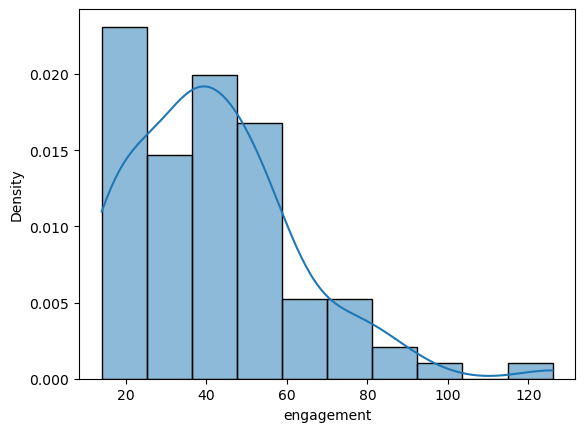

In [91]:
sb.histplot(data = data[data['network'] == 'Boomerang'][data['engagement'] < 500], x = 'engagement', kde = True, stat = 'density', label = 'engagement')

In [92]:
ss.normaltest(data[data['network'] == 'Boomerang'][data['engagement'] < 500]['engagement'], nan_policy = 'omit', axis = None)

C:\Users\mateu\AppData\Local\Temp\ipykernel_5708\2893371324.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ss.normaltest(data[data['network'] == 'Boomerang'][data['engagement'] < 500]['engagement'], nan_policy = 'omit', axis = None)


NormaltestResult(statistic=21.714226710374255, pvalue=1.926706579457682e-05)

C:\Users\mateu\AppData\Local\Temp\ipykernel_5708\3730040760.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sb.histplot(data = data[data['network'] == 'Cartoon Network'][data['engagement'] < 500], x = 'engagement', kde = True, stat = 'density', label = 'engagement')


<Axes: xlabel='engagement', ylabel='Density'>

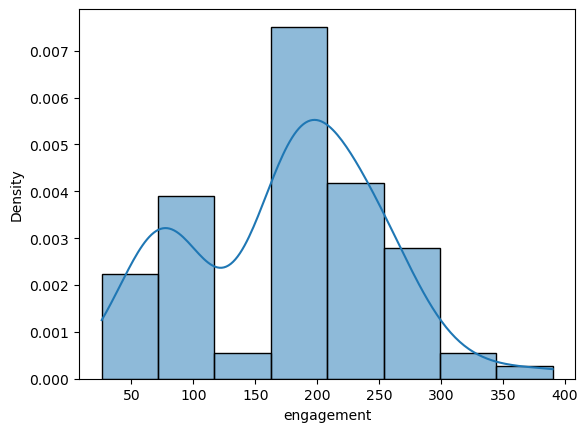

In [93]:
sb.histplot(data = data[data['network'] == 'Cartoon Network'][data['engagement'] < 500], x = 'engagement', kde = True, stat = 'density', label = 'engagement')

In [94]:
ss.normaltest(data[data['network'] == 'Cartoon Network'][data['engagement'] < 500]['engagement'], nan_policy = 'omit', axis = None)

C:\Users\mateu\AppData\Local\Temp\ipykernel_5708\1780968463.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ss.normaltest(data[data['network'] == 'Cartoon Network'][data['engagement'] < 500]['engagement'], nan_policy = 'omit', axis = None)


NormaltestResult(statistic=0.30813393316441023, pvalue=0.8572146143563755)

Jako ostatni element naszej analizy danych, wykonamy przykładowe t-testy dla średniej oraz wariancji dla zmiennej 'imdb'. T-testy dla zmiennej 'engagement' zostaly celowo pominięte, jako że wykres tej zmiennej nawet wizualnie nie przypomina rozkładu normalnego (oprócz stacji Cartoon Network - według testu normalności nie możemy odrzucić hipotezy, że jest to w tym przypadku rozkład normalny)

1. Równość średniej w próbce i w całej populacji

$H_0: m_0 = m$

$H_1: m_0 \ne m$

Jako kolejne próbki przyjmiemy produkcje emitowane przez stacje ABC, Boomerang, Cartoon Network oraz losowo wybrane próbki pełnej populacji.

In [95]:
abc_data = data[data['network'] == 'ABC']['imdb']

population_mean = 7.29

t, p = ss.ttest_1samp(abc_data, population_mean)
t, p

(-5.08136989660142, 6.858307181518568e-07)

In [96]:
b_data = data[data['network'] == 'Boomerang']['imdb']

population_mean = 7.29

t, p = ss.ttest_1samp(b_data, population_mean)
t, p

(3.0148647850977714, 0.003399339154011681)

In [97]:
cn_data = data[data['network'] == 'Cartoon Network']['imdb']

population_mean = 7.29

t, p = ss.ttest_1samp(cn_data, population_mean)
t, p

(8.571720069155885, 5.11954405074569e-13)

In [98]:
rnd_data = data['imdb'].sample(n = 100)

population_mean = 7.29

t, p = ss.ttest_1samp(rnd_data, population_mean)
t, p

(-0.857989943263302, 0.39297044922263946)

In [103]:
rnd_data = data['imdb'].sample(n = 30)

population_mean = 7.29

t, p = ss.ttest_1samp(rnd_data, population_mean)
t, p

(-0.6972203887085745, 0.49121697087149263)

Uzyskane wyniki dla poszczególnych stacji (p_wartości bliskie zeru, żadna nie przekracza nawet 0.05) sugerują odrzucenie hipotezy zerowej $H_0.$ Można założyć prawdziwość hipotezy $H_1$ oraz przyjąć, że średnie poszczególnych próbek różnią się od średniej dla pełnej populacji. 

Dla losowo wybranych próbek, wysoka p_wartość nie sugeruje odrzucenia hipotezy zerowej.

2. Równość średniej w poszczególnych próbkach

$H_0: m_1 = m_2$

$H_1: m_1 \ne m_2$

Jako kolejne próbki przyjmiemy produkcje emitowane przez stacje ABC, Boomerang, Cartoon Network oraz losowo wybrane próbki pełnej populacji.

In [104]:
abc_data = data[data['network'] == 'ABC']['imdb']
b_data = data[data['network'] == 'Boomerang']['imdb']

t, p = ss.ttest_ind(abc_data, b_data)
t, p

(-5.590132927027362, 4.457470582668716e-08)

In [105]:
abc_data = data[data['network'] == 'ABC']['imdb']
cn_data = data[data['network'] == 'Cartoon Network']['imdb']

t, p = ss.ttest_ind(abc_data, cn_data)
t, p

(-12.744765623238955, 5.459195509901487e-31)

In [106]:
abc_data = data[data['network'] == 'ABC']['imdb']
b_data = data[data['network'] == 'Boomerang']['imdb']

t, p = ss.ttest_ind(abc_data, cn_data)
t, p

(-12.744765623238955, 5.459195509901487e-31)

Uzyskane wyniki dla poszczególnych par stacji (p_wartości bliskie zeru, żadna nie przekracza nawet 0.05) sugerują odrzucenie hipotezy zerowej $H_0$. Można założyć prawdziwość hipotezy $H_1$ oraz przyjąć, że średnie poszczególnych próbek różnią się pomiędzy sobą.

3. Równość wariancji w próbce i całej populacji

$H_0: \sigma _1 = \sigma$

$H_1: \sigma _1 \ne \sigma$

Jako kolejne próbki przyjmiemy produkcje emitowane przez stacje ABC, Boomerang, Cartoon Network oraz losowo wybrane próbki pełnej populacji.

In [107]:
abc_data = data[data['network'] == 'ABC']['imdb']

t, p = ss.levene(abc_data, data['imdb'])
t, p

(45.18408334920374, 3.2113159010920723e-11)

In [108]:
b_data = data[data['network'] == 'Boomerang']['imdb']

t, p = ss.levene(b_data, data['imdb'])
t, p

(1.2483173253553865, 0.26426354652611994)

In [109]:
cn_data = data[data['network'] == 'Cartoon Network']['imdb']

t, p = ss.levene(cn_data, data['imdb'])
t, p

(0.008452226603532887, 0.9267756960456258)

In [110]:
rnd_data = data['imdb'].sample(n = 30)

t, p = ss.levene(rnd_data, data['imdb'])
t, p

(0.9349866804620882, 0.3339391839210534)

Uzyskane wyniki dla stacji 'ABC' (p_wartości bliska zeru) sugerują odrzucenie hipotezy zerowej $H_0.$ Można założyć prawdziwość hipotezy $H_1$ oraz przyjąć, że wariancja dla stacji 'ABC' różni się od wariancji dla pełnej populacji.  

Uzyskane wyniki dla stacji 'Boomerang' oraz 'Cartoon Network' nie pozwalają na odrzucenie hipotezy zerowej, ponieważ p-wartość jest odpowiednio wysoka (przekracza 0.2 dla stacji 'Boomerang', a dla stacji 'Cartoon Network' wynosi aż 0.92)

Dla losowo wybranej próbki, wysoka p-wartość również nie sugeruje odrzucenia hipotezy zerowej.

3. Równość wariancji w poszczególnych próbkach

$H_0: \sigma _1 = \sigma_2$

$H_1: \sigma _1 \ne \sigma_2$

Jako kolejne próbki przyjmiemy produkcje emitowane przez stacje ABC, Boomerang, Cartoon Network.

In [111]:
abc_data = data[data['network'] == 'ABC']['imdb']
b_data = data[data['network'] == 'Boomerang']['imdb']

t, p = ss.levene(abc_data, b_data)
t, p

(16.67013539519269, 5.4712885596956534e-05)

In [112]:
abc_data = data[data['network'] == 'ABC']['imdb']
cn_data = data[data['network'] == 'Cartoon Network']['imdb']

t, p = ss.levene(abc_data, cn_data)
t, p

(25.233282926971274, 7.994393342305082e-07)

In [113]:
b_data = data[data['network'] == 'Boomerang']['imdb']
cn_data = data[data['network'] == 'Cartoon Network']['imdb']

t, p = ss.levene(b_data, cn_data)
t, p

(0.7520951188344621, 0.38706559039088884)

Na podstawie uzyskanych p-wartości, możemy odrzucić hipotezę zerową $H_0$ w przypadku porównywania stacji 'ABC' i 'Boomerang' oraz 'ABC' i 'Cartoon Network' i przyjąć hipotezę alternatywną $H_1$ o nierówności wariancji dla kolejnych par stacji.

Na podstawie uzyskanych p-wartości, nie możemy odrzucić hipotezy zerowej $H_0$ w przypadku porównywania stacji 'Boomerang' i 'Cartoon Network'

# Podsumowanie

Wbrew oczekiwaniom, jednoznaczna odpowiedź na pytanie o aspekty czyniące produkcje z uniwersum Scooby-Doo atrakcyjnymi dla widza nie jest możliwa. Zmienne dotyczące oceny użytkowników oraz rozgłosu i zaangażowania poszczególnych filmów w większości przypadków nie korelują w znacznym stopniu z innymi, w związku z czym ciężko jest przewidzieć ocenę oraz zaangażowanie społeczności. W trakcie analizy danych oraz ich reprezentacji graficznej na wykresach, zauważone zostały cechy wpływające na ocenę oraz zaangażowanie w różnym stopniu, takie jak:

1. Zaangażowanie oraz popularność:
    - wytwórnia
    - producent
    - długość produkcji
    - ilość podejrzanych
    - ilość użytych powiedzonek

2. Ocena produkcji:
    - ilość potworów
    - występowanie faktycznego potwora
    - niepowodzenie śledztwa
    - dobór aktorów (choć niektórzy aktorzy wzięli udział w produkcjach zbyt mało razy, by móc mówić o reprezentatywnych danych)

Ze względu na słabą korelację pomiędzy oceną a zaangażowaniem, ciężko stwierdzić w jaki sposób zachowałyby się poszczególne wskaźniki przy próbie uwzględnienia wszystkich powyższych faktów. W celu lepszego zbadania zależności zaangażowania oraz oceny od wielu zmiennych konieczne jest obliczenie regresji dla wielu zmiennych. 